# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import typing
import string

import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import hashlib

import urllib.request
import urllib.parse
import keras_ocr
import imgaug
from sklearn.metrics import accuracy_score

tf.__version__

'2.4.1'

# Hyper-Parameters

In [3]:
DEFAULT_BUILD_PARAMS = {
    'height': 31,
    'width': 200,
    'color': False,
    'filters': (64, 128, 256, 256, 512, 512, 512),
    'rnn_units': (128, 128),
    'dropout': 0.25,
    'rnn_steps_to_discard': 2,
    'pool_size': 2,
    'stn': True,
}

DEFAULT_ALPHABET = string.digits + string.ascii_lowercase

PRETRAINED_WEIGHTS = {
    'kurapan': {
        'alphabet': DEFAULT_ALPHABET,
        'build_params': DEFAULT_BUILD_PARAMS,
        'weights': {
            'notop': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan_notop.h5',
                'filename': 'crnn_kurapan_notop.h5',
                'sha256': '027fd2cced3cbea0c4f5894bb8e9e85bac04f11daf96b8fdcf1e4ee95dcf51b9'
            },
            'top': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan.h5',
                'filename': 'crnn_kurapan.h5',
                'sha256': 'a7d8086ac8f5c3d6a0a828f7d6fbabcaf815415dd125c32533013f85603be46d'
            }
        }
    }
}

# Preprocessing

In [4]:

# Path to the data directory
data_dir = Path("../assets/dataset")
csv_file = "../assets/dataset/dataset.csv"

input_df = pd.read_csv(csv_file, header=None,names=['Image', 'label'])
input_df["Image"] = input_df["Image"].apply(lambda s: ('hdr/' if list(str(s).split('/')[0].split('_')[1])[0] == 'h' else "normal/") +s) 
input_df["Image"] = input_df["Image"].apply(lambda s: os.path.join(data_dir,s))
input_df["label"] = input_df["label"].str.strip()
input_df["label"] = input_df["label"].str.lower()
input_df.insert(1, "mask", None)
# Get list of all the images
images = input_df["Image"] 
labels = input_df["label"] 
characters = set(char for label in labels for char in label)
alphabet="".join(characters)
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 1

# Desired image dimensions
img_width = 200
img_height = 31

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  652
Number of labels found:  652
Number of unique characters:  31
Characters present:  {'7', 'c', '3', 't', '2', 'l', 'p', 's', 'x', 'h', '8', '0', 'b', '4', 'j', 'e', '6', 'k', 'i', 'z', 'a', '5', 'g', 'd', '9', 'f', 'n', 'm', 'v', '1', 'r'}


# Model

In [5]:
recognizer = keras_ocr.recognition.Recognizer( weights='kurapan')
recognizer.compile()

Looking for /root/.keras-ocr/crnn_kurapan.h5


# Dataset 

In [6]:
input_labels = [tuple(x) for x in input_df.values]

In [7]:
train_df,test_df = train_test_split(input_labels,test_size=0.20, random_state=42,shuffle=True)
train_df,validation_df = train_test_split(train_df,test_size=0.05, random_state=42,shuffle=True)

In [8]:
batch_size = 128
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),

], random_order=True)

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_df, augmenter), (validation_df, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

# Visualize the data

text: bvj6411


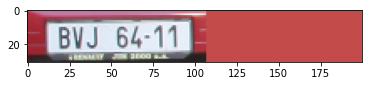

In [9]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

# Model summary

In [10]:
recognizer.training_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31, 200, 1)] 0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 200, 31, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 200, 31, 1)   0           permute[0][0]                    
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 200, 31, 64)  640         lambda[0][0]                     
____________________________________________________________________________________________

# Training

In [11]:

epochs = 150
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('..assets/dataset/trained_recognizer.h5', monitor='loss', save_best_only=True)

callbacks = [
    early_stopping,
    reduce_lr,
     model_checkpoint,
]

history = recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=epochs,
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
3/3 [==============================] - 21s 2s/step - loss: 55.9898
Epoch 2/150
3/3 [==============================] - 3s 1s/step - loss: 22.9671
Epoch 3/150
3/3 [==============================] - 3s 940ms/step - loss: 16.9904
Epoch 4/150
3/3 [==============================] - 3s 988ms/step - loss: 15.2007
Epoch 5/150
3/3 [==============================] - 3s 920ms/step - loss: 11.4014
Epoch 6/150
3/3 [==============================] - 3s 1s/step - loss: 8.9478
Epoch 7/150
3/3 [==============================] - 3s 927ms/step - loss: 6.2666
Epoch 8/150
3/3 [==============================] - 3s 1s/step - loss: 5.8261
Epoch 9/150
3/3 [==============================] - 3s 1s/step - loss: 5.4505
Epoch 10/150
3/3 [==============================] - 3s 1s/step - loss: 2.9791
Epoch 11/150
3/3 [==============================] - 3s 977ms/step - loss: 2.5586
Epoch 12/150
3/3 [==============================] - 3s 959ms/step - loss: 1.8499
Epoch 13/150
3/3 [==============================]

# Performance

<AxesSubplot:>

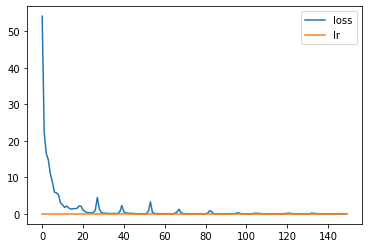

In [12]:
pd.DataFrame(history.history).plot()

# Inference

In [13]:
y_true = []
y_pred= []
for i in range(len(test_df)):
    image_filepath, _, actual = test_df[i]
    predicted = recognizer.recognize(image_filepath)
    
    y_true.append(actual)
    y_pred.append(predicted)

In [14]:
print("Accuracy on test data",accuracy_score(y_true, y_pred)*100)

Accuracy on test data 76.33587786259542


# Inference Viz

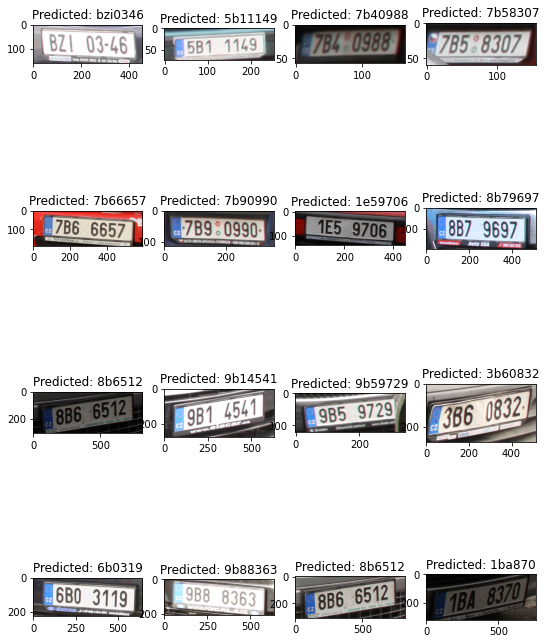

In [15]:
w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image_filepath, _, actual = test_df[i]
    predicted = recognizer.recognize(image_filepath)
    

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(f'Predicted: {predicted}')  # set title
    plt.imshow(keras_ocr.tools.read(image_filepath))


plt.show()  # finally, render the plot
